In [3]:
"""

Bar & Spiral simulation

By: Lilia Correa Magnus

This simulation is modelled using Galpy and follows 
Jason A. S. Hunt et al's "Transient spiral structure and 
the disc velocity substructure in Gaia DR2" paper. 

Produces velocity distribution graphs in the U-V plane &
individual orbit integration graphs
for different spiral & bar scenarios (fast and slow bars)
as well as two different galpy wrapper combinations.

It also produces graphs 

All values are in Galpy's natural units.

"""


from galpy.potential import DehnenBarPotential, SolidBodyRotationWrapperPotential, MWPotential2014
from galpy.potential import CosmphiDiskPotential
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from galpy.orbit import Orbit
from galpy.potential import SpiralArmsPotential, CorotatingRotationWrapperPotential, GaussianAmplitudeWrapperPotential
from galpy.util import bovy_conversion
from galpy.potential import DehnenSmoothWrapperPotential
from galpy.df import evolveddiskdf
from galpy.df import dehnendf
from scipy import ndimage as nd
from galpy.util import bovy_plot

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

#reading Gaia DR2 file 
infile = 'nearby_stars_nan.csv'
f = open(infile)
firstcol = f.readline()

kvals = firstcol.split(',')
print('Keys:',kvals)
formats = ['f8' for i in range(0,len(kvals))]

N = np.genfromtxt(infile,dtype={'names': kvals,'formats': formats},skip_header=1,delimiter=',')

#base potential
MWpot=MWPotential2014

# setting up integration parameters as seen in Hunt et al fig. 2
t=[1.72,0.86,0.57,0.43,0.34,0.29]
L=[40,80,120,160,200,240]

#inputs for the bar potential wrappers converted to Galpy units
vel_conv=220/bovy_conversion.velocity_in_kpcGyr(220,8)
Af=0.01*((vel_conv*vel_conv)/3)*(8/5)**3


Keys: ['x', 'y', 'z', 'vx', 'vy', 'vz', 'gmag', 'bprp\n']


In [ ]:
"""

Spiral and bar model where the bar 
is smoothly grown and both the bar
and spiral potentials are rotated using 
the same galpy rotation wrapper;
'solid body rotation wrapper'.

"""

# setting up a non-rotating spiral arm potential
omega_spiral = 1/bovy_conversion.freq_in_Gyr(220.,5.)
sp = SpiralArmsPotential(N=2,Rs=0.3,H=0.125,amp=1.,phi_ref=np.pi/2.,alpha=np.deg2rad(12))

#rotating the spiral around the z-axis
rwsp=SolidBodyRotationWrapperPotential(pot=sp, omega=omega_spiral)  


#setting up bar potential
"""

parameters for short/fast bar:

short fast bar inputs: rb=3.5, omega_bar=1.85
long slow bar inputs: rb=5, omega_bar=1.3

"""

omega_bar = 1.85/bovy_conversion.freq_in_kmskpc(220.,5.)
cmp=CosmphiDiskPotential(m=2,p=-3,rb=3.5,ro=8,vo=220)


"""

Loop to print out a grid of 4x4 models
of the solar neighbourhood in the UV plane

"""

counter=0

#setting up figure
plt.figure(figsize=(10,10))

for i in range (0,4):
    for j in range (0,4):
        counter+=1
        
        lifetime = L[i]/(1000.*bovy_conversion.time_in_Gyr(220.,8.)) 
        tpeak = -t[j]/bovy_conversion.time_in_Gyr(220.,8.)          
        sigmao = lifetime/5.6                                       
        to = tpeak                                                  
        tform = tpeak - lifetime/2.         
        
        
        #smoothly growing the bar & including rotation
        rwdb=SolidBodyRotationWrapperPotential(pot=DehnenSmoothWrapperPotential(pot=cmp, 
                                    tform=tform, amp=Af, ro=8, vo=220), omega=omega_bar)
        
        #denhnen distribution function to model the stellar disc
        dfc=dehnendf(beta=0.,correct=True)

        # integrate backward to the defined tform above
        edf=evolveddiskdf(dfc,MWpot+rwdb+rwsp,to=tform)

        # Calculate the velocity field upon a grid:
        %time mvr, grid= edf.meanvR(1.,phi=0.,deg=False,t=0.,grid=True,returnGrid=True,gridpoints=40)
    
        plt.subplot(4,4,counter)
        bovy_plot.bovy_dens2d(nd.gaussian_filter(grid.df[::-1].T,1.),
                    origin='lower',contours=True,xrange=[grid.vRgrid[0]*220.,grid.vRgrid[-1]*220.],
                    yrange=[grid.vTgrid[0]*220.,grid.vTgrid[-1]*220.],gcf=True,cmap='plasma')
        
        
        #save plot 
        #plt.savefig("vT_vR_csp_cmp_dbp" + str(counter) + ".png", format="PNG")  



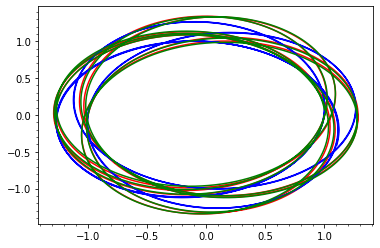

In [7]:
"""

Orbit intergration for an object in the solar neighbourhood 
for spiral+bar model where rotation is 
implemented with the solid rotation wrapper.

note: overplot=False will produce separate graphs

"""

#3D orbit for spiral potential
o=Orbit(vxvv=[1.,0.1,1.1,0.,0.1,0.])
    
#2D orbit for bar potential
op=Orbit([1,0.1,1.1,0.])

# setting up a non-rotating spiral arm potential
omega_spiral = 1/bovy_conversion.freq_in_Gyr(220.,5.)
sp = SpiralArmsPotential(N=2,Rs=0.3,H=0.125,amp=1.,phi_ref=np.pi/2.,alpha=np.deg2rad(12))

#rotating the spiral around the z-axis
omega_bar = 1.85/bovy_conversion.freq_in_kmskpc(220.,5.)
cmp=CosmphiDiskPotential(m=2,p=-3,rb=3.5,ro=8,vo=220)

rwsp=SolidBodyRotationWrapperPotential(pot=sp, omega=omega_spiral) 


#for i in range (0,4):
#for j in range (0,4):

lifetime = 160/(1000.*bovy_conversion.time_in_Gyr(220.,8.)) #minimal working example for the orbits
tpeak = -1.72/bovy_conversion.time_in_Gyr(220.,8.)          
sigmao = lifetime/5.6                                       
to = tpeak                                                  
tform = tpeak - lifetime/2.
ts=np.linspace(0,tform,1000)

rwdb=SolidBodyRotationWrapperPotential(pot=DehnenSmoothWrapperPotential(pot=cmp, 
                            tform=tform, amp=Af, ro=8, vo=220), omega=omega_bar)

#spiral 
o.integrate(ts,MWpot+rwsp,method='odeint')
o.plot(d1='x',d2='y',color='red', overplot=True)

#bar
op.integrate(ts,MWpot+rwdb,method='odeint')
op.plot(d1='x',d2='y',color='blue', overplot=True)

#rotating bar+spiral
op.integrate(ts,MWpot+rwdb+rwsp,method='odeint')
op.plot(d1='x',d2='y',color='green', overplot=True)


CPU times: user 45.1 s, sys: 48.8 ms, total: 45.1 s
Wall time: 45.2 s
/Users/liliacorreamagnus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10



array([[2.29391946e-05, 2.07851807e-05, 2.90866952e-05, ...,
        2.98652586e-05, 1.32045980e-05, 6.36912414e-06],
       [3.14687821e-05, 2.77384197e-05, 3.58720714e-05, ...,
        3.48679968e-05, 1.54828587e-05, 7.58549725e-06],
       [2.91719990e-05, 3.41060277e-05, 4.77746027e-05, ...,
        4.33694406e-05, 1.89618753e-05, 9.41205463e-06],
       ...,
       [1.51103929e-26, 3.04178697e-25, 7.40938959e-24, ...,
        1.63905695e-26, 5.67172923e-30, 9.33819635e-33],
       [1.42828036e-27, 4.12639433e-26, 8.14672870e-25, ...,
        1.53468743e-30, 4.53522049e-32, 1.41432361e-33],
       [6.56116521e-29, 2.81113462e-27, 7.35203571e-26, ...,
        1.85616525e-31, 5.42125963e-33, 1.25982791e-34]])

<Figure size 720x720 with 0 Axes>

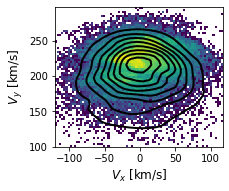

In [14]:
"""

Spiral and bar model where the bar is
smoothly grown. The bar is rotated 
using the rotation wrapper and the spiral
is rotated using the corotating wrapper.

This cell has also been modified to overplot
GDR2 data on the produced models.

"""
#set up spiral arms potential
omega_spiral = 1.3/bovy_conversion.freq_in_Gyr(220.,5.)
sp = SpiralArmsPotential(N=2,Rs=0.3,H=0.125,amp=1,phi_ref=np.pi/2.,alpha=np.deg2rad(12),omega=omega_spiral)

                         
#setting up bar potential
                         
"""

parameters for short/fast bar:

short fast bar inputs: rb=3.5, omega_bar=1.85
long slow bar inputs: rb=5, omega_bar=1.3

"""

omega_bar = 1.3/bovy_conversion.freq_in_kmskpc(220.,5.)
cmp=CosmphiDiskPotential(m=2,p=-3,rb=3.5,ro=8,vo=220)

counter=0
plt.figure(figsize=(10,10))


#for i in range (0,4):
 #   for j in range (0,4):
counter+=1

lifetime = 40/(1000.*bovy_conversion.time_in_Gyr(220.,8.)) 
tpeak = -0.43/bovy_conversion.time_in_Gyr(220.,8.)          
sigmao = lifetime/5.6                                       
to = tpeak                                                  
tform = tpeak - lifetime/2.                                

#setting up rotation of spiral arms with fixed R around z axis
crwp=CorotatingRotationWrapperPotential(pot=sp,vpo=1.,to=to)

#smoothly growing the bar & adding rotation
rwdb=SolidBodyRotationWrapperPotential(pot=DehnenSmoothWrapperPotential(pot=cmp, 
                            tform=tform, amp=Af, ro=8, vo=220), omega=omega_bar)                 


#denhnen distribution function to model the stellar disc
dfc=dehnendf(beta=0.,correct=True)

# integrate backward to the defined tform above
edf=evolveddiskdf(dfc,MWpot+rwdb+crwp,to=tform)

# Calculate the velocity field upon a grid
%time mvr, grid = edf.meanvR(1.,phi=0.,deg=False,t=0.,grid=True,returnGrid=True,gridpoints=40)

#plt.subplot(4,4,counter)

"""

The following piece of code adds a contour plot of the vR vs vT 
for a set of stars from Gaia DR2 .

"""

# make X km/s bins
kmres = 3
vrvals = np.arange(-120,120,kmres)
vtvals = np.arange(100,300,kmres)
img = np.zeros([vrvals.size,vtvals.size])

Nxindx = (np.floor((N['vx'] - np.nanmin(vrvals))/(kmres))).astype('int')
Nyindx = (np.floor((N['vy'] - np.nanmin(vtvals))/(kmres))).astype('int')

for vrv in range(0,vrvals.size):
    for vtv in range(0,vtvals.size):
        w = np.where((Nxindx==vrv) & (Nyindx==vtv))[0]
        #print(len(w))
        img[vrv,vtv] += len(w)

img = img.T

#plt.savefig("vT_vR_csp_cmp_dbp" + str(counter) + ".png", format="PNG")  

plt.figure(figsize=(3,3))
plt.imshow(np.log10(img),origin='lower',\
   extent=(np.nanmin(vrvals),np.nanmax(vrvals),np.nanmin(vtvals),np.nanmax(vtvals)),\
   cmap=cm.viridis)

plt.xlabel('$V_x$ [km/s]',size=12)
plt.ylabel('$V_y$ [km/s]',size=12)

# plt.contour(vrgrid,vtgrid,np.log10(img), colors='black')
bovy_plot.bovy_dens2d(nd.gaussian_filter(grid.df[::-1].T,1.), overplot=True,
              origin='lower',justcontours=True,xrange=[grid.vRgrid[0]*220.,grid.vRgrid[-1]*220.],
              yrange=[grid.vTgrid[0]*220.,grid.vTgrid[-1]*220.],gcf=True,cmap='viridis', cntrlw=2)





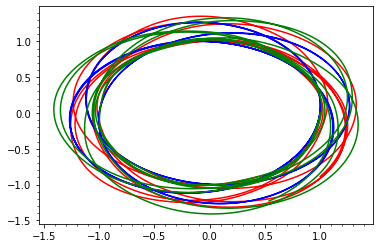

In [11]:
"""

Orbit integration for an object in the solar neighbourhood 
for spiral+bar model where rotation for spiral is 
implemented with the corotation wrapper.

"""


# setting up a non-rotating spiral arm potential
omega_spiral = 1/bovy_conversion.freq_in_Gyr(220.,5.)
sp = SpiralArmsPotential(N=2,Rs=0.3,H=0.125,amp=1.,phi_ref=np.pi/2.,alpha=np.deg2rad(12))

#rotating the spiral around the z-axis
omega_bar = 1.85/bovy_conversion.freq_in_kmskpc(220.,5.)
cmp=CosmphiDiskPotential(m=2,p=-3,rb=5,ro=8,vo=220)


#3D orbit for spiral potential, 
o=Orbit(vxvv=[1.,0.1,1.1,0.,0.1,0.])
    
#2D orbit for bar potential
op=Orbit([1,0.1,1.1,0.])
    

#for i in range (0,4):
lifetime = 200/(1000.*bovy_conversion.time_in_Gyr(220.,8.)) 
tpeak = -1.72/bovy_conversion.time_in_Gyr(220.,8.)          
sigmao = lifetime/5.6                                       
to = tpeak                                                  
tform = tpeak - lifetime/2.
ts=np.linspace(0,tform,1000)

rwdb=SolidBodyRotationWrapperPotential(pot=DehnenSmoothWrapperPotential(pot=cmp, 
                            tform=tform, amp=Af, ro=8, vo=220), omega=omega_bar)

crwp=CorotatingRotationWrapperPotential(pot=sp,vpo=1.,to=to)
"""
#spiral 
o.integrate(ts,MWpot+crwp,method='odeint')
o.plot(d1='x',d2='y',color='red', overplot=True)

#bar
op.integrate(ts,MWpot+rwdb,method='odeint')
op.plot(d1='x',d2='y',color='blue', overplot=True)
"""
#rotating bar+spiral
op.integrate(ts,MWpot+rwdb+crwp,method='odeint')
op.plot(d1='x',d2='y',color='green', overplot=True)


In [ ]:
"""

Code to read GDR2 csv file 
and plot v_T against v_R both
binning the data and contour plotting.

These pieces of code can be added onto the 
cells above to overplot the observed data 
on the simulated models.

"""

#reading Gaia DR2 file 
infile = 'nearby_stars_nan.csv'
f = open(infile)
firstcol = f.readline()

kvals = firstcol.split(',')
print('Keys:',kvals)
formats = ['f8' for i in range(0,len(kvals))]

N = np.genfromtxt(infile,dtype={'names': kvals,'formats': formats},skip_header=1,delimiter=',')

"""
        
Following piece of code adds the contour of the vR vs vT 
graph plotted using a set of stars from Gaia DR2 

"""

# make X km/s bins
kmres = 3
vrvals = np.arange(-120,120,kmres)
vtvals = np.arange(100,300,kmres)
img = np.zeros([vrvals.size,vtvals.size])

Nxindx = (np.floor((N['vx'] - np.nanmin(vrvals))/(kmres))).astype('int')
Nyindx = (np.floor((N['vy'] - np.nanmin(vtvals))/(kmres))).astype('int')

"""

This loop sweeps through the 
plot and counts the amount of points
Nyinx & Nxinx that coincide at a specific 
pixel

"""

for vrv in range(0,vrvals.size):
    for vtv in range(0,vtvals.size):
        w = np.where((Nxindx==vrv) & (Nyindx==vtv))[0]
        #print(len(w))
        img[vrv,vtv] += len(w)

img = img.T

#produce contour
vrgrid,vtgrid = np.meshgrid(vrvals,vtvals)
plt.contour(vrgrid,vtgrid,np.log10(img))

plt.xlabel('$V_x$ [km/s]',size=12)
plt.ylabel('$V_y$ [km/s]',size=12)

#produce image of binned data
plt.imshow(np.log10(img),origin='lower',\
        extent=(np.nanmin(vrvals),np.nanmax(vrvals),np.nanmin(vtvals),np.nanmax(vtvals)),\
           cmap=cm.Greys)

plt.xlabel('$V_x$ [km/s]',size=12)
plt.ylabel('$V_y$ [km/s]',size=12)


"""

Use the code below to produce an over plot 
where the simulated model is shown as a contour
and the observed data as 'pixels'.

"""

plt.imshow(np.log10(img),origin='lower',\
   extent=(np.nanmin(vrvals),np.nanmax(vrvals),np.nanmin(vtvals),np.nanmax(vtvals)),\
   cmap=cm.viridis)

# plt.contour(vrgrid,vtgrid,np.log10(img), colors='black')
bovy_plot.bovy_dens2d(nd.gaussian_filter(grid.df[::-1].T,1.), overplot=True,
              origin='lower',justcontours=True,xrange=[grid.vRgrid[0]*220.,grid.vRgrid[-1]*220.],
              yrange=[grid.vTgrid[0]*220.,grid.vTgrid[-1]*220.],gcf=True,cmap='viridis', cntrlw=1)



